<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Декомпозиция-временного-ряда" data-toc-modified-id="Декомпозиция-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Декомпозиция временного ряда</a></span></li><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Добавление признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Предсказание-целевого-признака-с-помощью-LinearRegression" data-toc-modified-id="Предсказание-целевого-признака-с-помощью-LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Предсказание целевого признака с помощью LinearRegression</a></span></li><li><span><a href="#Предсказание-целевого-признака-с-помощью-CatBoostRegressor" data-toc-modified-id="Предсказание-целевого-признака-с-помощью-CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Предсказание целевого признака с помощью CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col=[0])
df.shape

(26496, 1)

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [4]:
df.isna().sum()

num_orders    0
dtype: int64

Данные чистые, отсортированы по индексу в хронологическом порядке, пустот нет. можно приступать к анализу временного ряда.

## Анализ

### Декомпозиция временного ряда

На данном этапе я проанализирую тренд временного ряда, определю его период сезонности.

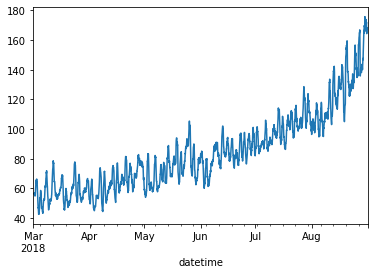

In [5]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot();

На графике тренда мы видим, что тренд плавный восходящий, начиная с марта и до августа, количество заказов такси растет.

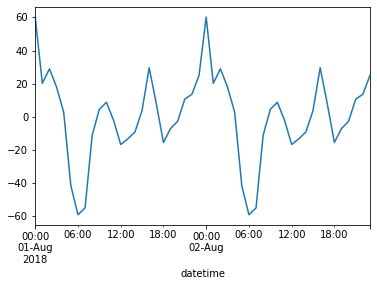

In [6]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot();

На графике видно, что сезонность у нас циклична. Цикл повторяется каждый день, наблюдается внутрисуточная сезонность. 

Начиная с 00:00 и до 6:00 утра активность падает. В 6 утра фиксируется минимум активности, далее график идет в рост, с колебаниями в районе 12 часов дня и 18 часов вечера. Далее количество заказов достигает своего максимума в 00:00 и потом цикл повторяется.

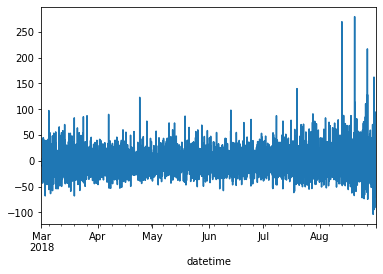

In [7]:
decomposed.resid.plot();#шумы

Рассмотрим, есть ли в данных дневная сезонность и какая она.

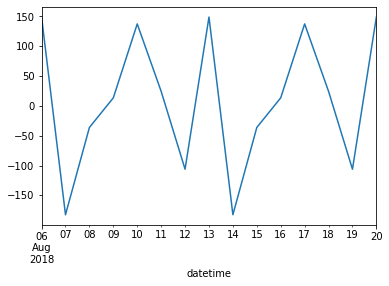

In [8]:
df_day = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col=[0])
df_day.sort_index(inplace=True)
df_day = df_day.resample('1D').sum()
decomp_day = seasonal_decompose(df_day)
decomp_day.seasonal['2018-08-06':'2018-08-20'].plot();

На данном графике мы видим что есть закономерность в данных в рамках недели: с пн на вт наблюдается спад в количестве заказов, далее идет уверенный рост до пятницы,с сб на вс наблюдаем снова спад, потом цикл повторяется. значит здесь и дневная сезонность.

### Добавление признаков


Добавим в датасет численные признаки, а именно: день недели, час.

In [9]:
#функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()




In [10]:
make_features(df,168,24)

In [11]:
df.head(5)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

В данной задаче я решила протестировать следующие модели: DummyRegressor, LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor. 

Сначала я разделю датасет на выборки, тестовую и обучающую. 
Далее, проведу подбор гиперпараметров для RandomForestRegressor, DecisionTreeRegressor, CatBoostRegressor. Потом произведу обучение моделей по полученным гиперпараметрам и выполню предсказания.

In [12]:
#поделим на выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [13]:
print(train.shape, test.shape)

(3806, 172) (442, 172)


In [14]:
#определим цели и признаки
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [15]:
#задаим функцию rmse что бы использовать ее в гридсерч.
def rmse(y_true, y_predicted):
    return mean_squared_error(y_true, y_predicted, squared=False)
scoring = make_scorer(rmse, greater_is_better=False)

#создадим список,который пополним данными по гиперпараметрам каждой модели
results_gridsearch = []
tscv = TimeSeriesSplit(n_splits=3)
random_state = 42

### Подбор гиперпараметров

Запустим  GridSearchCV сначала для DecisionTreeRegressor, что бы найти глубину дерева, потом данное значение будем использовать в модели RandomForestRegressor и подберем непосредственно количество деревьев.

In [16]:
param = {'max_depth': range(1,10), 'min_samples_leaf':range(2,10)}
model = DecisionTreeRegressor(random_state = random_state)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param, 
                           n_jobs=-1, cv=tscv, verbose=1, 
                           scoring=scoring)

grid_search.fit(train_features,train_target)

results_gridsearch.append({'model name': model.__class__.__name__, 
                              'Best parametres': grid_search.best_params_,'Best score': abs(grid_search.best_score_)}) 

max_depth = grid_search.best_params_.get('max_depth')
min_samples_leaf = grid_search.best_params_.get('min_samples_leaf')

pd.DataFrame(results_gridsearch)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


,model name,Best parametres,Best score
0,DecisionTreeRegressor,"{'max_depth': 4, 'min_samples_leaf': 9}",27.024577


Используем найденную глубину дерева для того чтобы подобрать гипермпараметр n_estimators в RandomForestRegressor.

In [17]:
param = {'n_estimators':range(10,101,10)}
model = RandomForestRegressor(random_state=random_state, 
                              max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param, 
                           n_jobs=-1, cv=tscv, verbose=1, 
                           scoring=scoring)

grid_search.fit(train_features,train_target)

results_gridsearch.append({'model name': model.__class__.__name__, 
                              'Best parametres': grid_search.best_params_,'Best score': abs(grid_search.best_score_)}) 

n_estimators = grid_search.best_params_.get('n_estimators')
pd.DataFrame(results_gridsearch)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,model name,Best parametres,Best score
0,DecisionTreeRegressor,"{'max_depth': 4, 'min_samples_leaf': 9}",27.024577
1,RandomForestRegressor,{'n_estimators': 50},24.723514


Используем найденные значения,чтобы обучить модель CatBoost.

In [18]:
param = {'learning_rate': [0.01, 0.05, 0.1],
         'iterations': [200, 500, 1000]}

model = CatBoostRegressor(random_state=random_state, 
                          verbose=False,
                          depth=max_depth)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param, 
                           n_jobs=-1, cv=tscv, verbose=1, 
                           scoring=scoring)

grid_search.fit(train_features,train_target)
results_gridsearch.append({'model name': model.__class__.__name__, 
                              'Best parametres': grid_search.best_params_,'Best score': abs(grid_search.best_score_)}) 

pd.DataFrame(results_gridsearch)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


,model name,Best parametres,Best score
0,DecisionTreeRegressor,"{'max_depth': 4, 'min_samples_leaf': 9}",27.024577
1,RandomForestRegressor,{'n_estimators': 50},24.723514
2,CatBoostRegressor,"{'iterations': 1000, 'learning_rate': 0.01}",23.205592


Итоговые вычисления моделей, с учетом всех подобранных гиперпараметров.

In [19]:
iterations = grid_search.best_params_.get('iterations')
learning_rate = grid_search.best_params_.get('learning_rate')

models = [CatBoostRegressor(random_state=random_state,
                            verbose=False,
                            depth=max_depth,
                           iterations = iterations,
                           learning_rate = learning_rate), 
          DecisionTreeRegressor(random_state = random_state, 
                                max_depth=max_depth, 
                               min_samples_leaf = min_samples_leaf), 
          RandomForestRegressor(random_state=random_state, 
                                max_depth=max_depth, 
                                n_estimators = n_estimators,
                                min_samples_leaf = min_samples_leaf), 
          LinearRegression(),
          DummyRegressor()]


results_predict = []

for model in models:
    model.fit(train_features,train_target)
    prediction = model.predict(train_features)
    rmse = mean_squared_error(train_target, prediction, squared=False)
    
    
    results_predict.append({'model name': model.__class__.__name__, 
                              'RMSE': rmse}) 
              
pd.DataFrame(results_predict)

,model name,RMSE
0,CatBoostRegressor,19.145352
1,DecisionTreeRegressor,22.778248
2,RandomForestRegressor,21.193903
3,LinearRegression,20.506528
4,DummyRegressor,38.678217


Интересно, что наипростейшая модель LinearRegression справилась на уровне сложной модели CatBoostRegressor. Возьмем эти две модели и проведем итоговое предсказание на тестовой выборке, посмотрим кто точнее сможет предсказать  временной ряд.

## Тестирование

Выполним предсказания целевого признака на тестовой выборке.

### Предсказание целевого признака с помощью LinearRegression

In [20]:
model = LinearRegression()
model.fit(train_features,train_target)
prediction = model.predict(test_features)
rmse = mean_squared_error(test_target, prediction, squared=False)
rmse

34.578633781810865

In [21]:
pred = pd.Series(prediction, index=test.index)
target = test_target[:49]#48часов
pred = pred[:49]

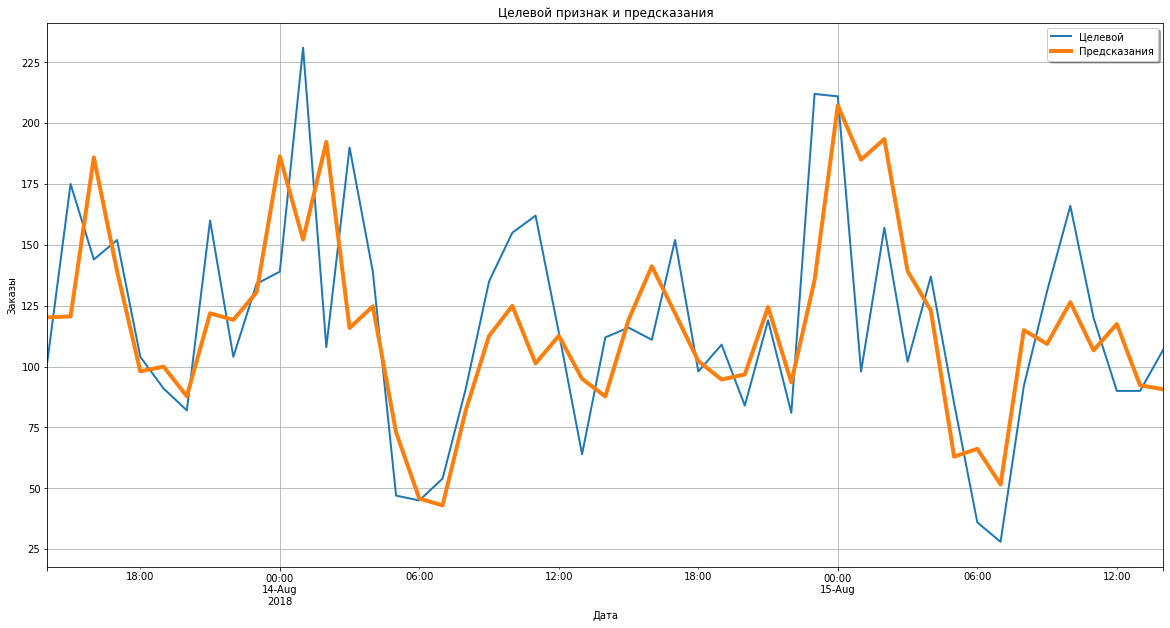

In [22]:
plt.figure(figsize=(20, 10))
a = target.plot(linewidth=2, label="Целевой")
pred.plot(ax=a,linewidth=4, label="Предсказания")
plt.title("Целевой признак и предсказания")
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show();

### Предсказание целевого признака с помощью CatBoostRegressor

In [23]:
model = CatBoostRegressor(random_state=random_state,
                            verbose=False,
                            depth=max_depth,
                           iterations = iterations,
                           learning_rate = learning_rate)
model.fit(train_features,train_target)
prediction = model.predict(test_features)
rmse = mean_squared_error(test_target, prediction, squared=False)
rmse

37.70569871339322

In [24]:
pred = pd.Series(prediction, index=test.index)
target = test_target[:49]
pred = pred[:49]

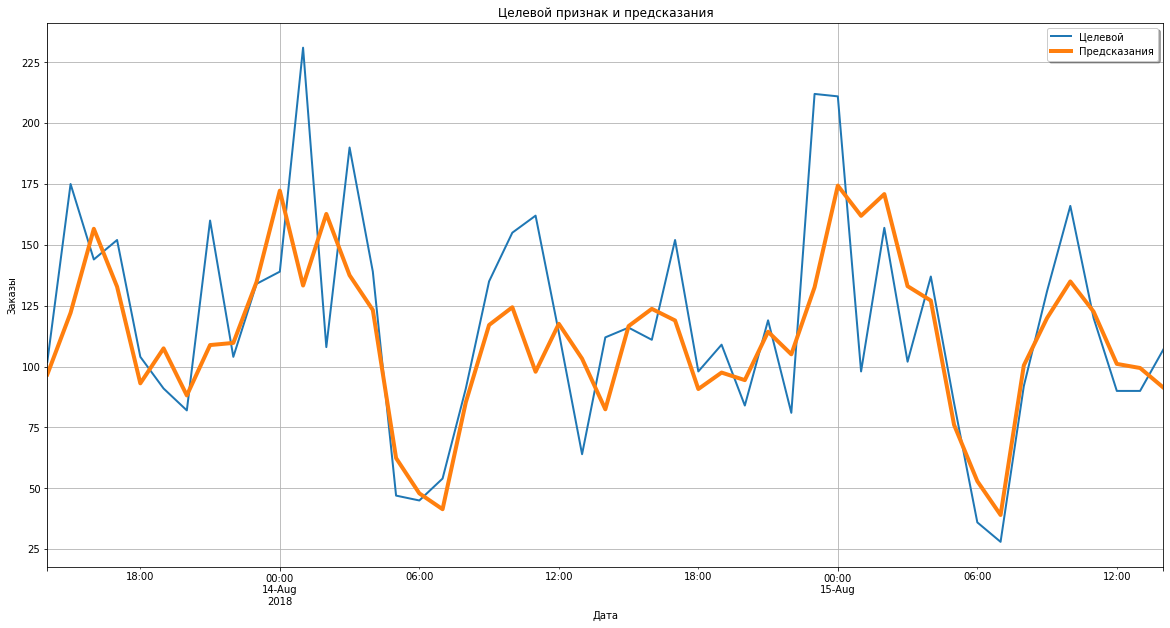

In [25]:
plt.figure(figsize=(20, 10))
a = target.plot(linewidth=2, label="Целевой")
pred.plot(ax=a,linewidth=4, label="Предсказания")
plt.title("Целевой признак и предсказания")
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show();

На графике можно увидеть качество предсказания наших моделей. Обе модели имеют сильные погрешности в период с 6 до 12 часов, и с 00 до 6 утра. 
Однако, модели линейной регрессии показала более точные результаты, это видно и по метрике, и по тому как график предсказаний повторяет график целевого признака.

Интересно, что это две принципиально разные модели, однако с предсказанием они справились одинаково, при этом ресурсозатратность у них очень отличается. Думаю, выбор модели зависит от того какую цель преследует бизнес, какова длительность прогнозирования и пр..